# Determining the cost of cars

Service for the sale of used cars "No Accidents" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- prediction speed;
- studying time.

## Data preparation

In [1]:
#conda install lightgbm

In [2]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb

from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_csv("/Users/vzuga/Documents/jupyter/datasets/autos.csv")
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
def data_check(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Duplicates:', data.duplicated().sum())
    print()
    print('Missing values')
    print(data.isna().mean())   
    print()
    print('Statistics')
    print(data.describe())

In [5]:
data_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Duplicates: 4

Missing values
DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Statistics
               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       200

### Conclusions:
* rename column names
* convert dates to DateTime
* there are gaps in not_repaired, vehicle_type, fuel_type, gearbox, model
* 4 obvious duplicates
* abnormal values in price, registration_year, power
* number_of_pictures only zeros

### Renaming columns

In [6]:
df.columns = df.columns.str.lower()

df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### DateTime

Convert the following columns to DateTime format:
*date_crawled
*date_created
* last_seen

In [7]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

Check the registration_month column. It may be possible to combine it with registration_year and also convert it to DateTime.

In [8]:
df['registration_month'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registration_month, dtype: int64

Since there is a zero month and there are a lot of these values, I will leave it as it is.

### Passes

I'll start with the passes in the type of vehicle. Perhaps the data on the missing types can be taken from the model-vehicle type link.

In [9]:
#amout of all car models
len(df.model.unique())

251

In [10]:
#unique values of models and types
df[['model', 'vehicle_type']].dropna().drop_duplicates()

,model,vehicle_type
2,grand,suv
3,golf,small
4,fabia,small
5,3er,sedan
6,2_reihe,convertible
...,...,...
339350,m_reihe,suv
340012,fox,convertible
344028,note,other
351588,zafira,coupe


In [11]:
#how many types of vehicle corresponds to each model
#last 15 of 251 entries
df[['model', 'vehicle_type']].dropna().drop_duplicates()['model'].value_counts(ascending=False).tail(15)

sorento               2
850                   2
x_type                2
range_rover_sport     1
serie_3               1
phaeton               1
captiva               1
range_rover           1
cherokee              1
b_max                 1
gl                    1
range_rover_evoque    1
eos                   1
s60                   1
serie_1               1
Name: model, dtype: int64

It can be seen that almost every model corresponds to 2 or more different types. It is not possible to replace gaps from this data. I'll look at the type values for some models.

In [12]:
df[['model', 'vehicle_type']].dropna().drop_duplicates().query('model=="golf"')

,model,vehicle_type
3,golf,small
32,golf,sedan
189,golf,bus
191,golf,other
195,golf,wagon
219,golf,convertible
1108,golf,coupe
32468,golf,suv


In [13]:
df[['model', 'vehicle_type']].dropna().drop_duplicates().query('model=="passat"')

,model,vehicle_type
11,passat,wagon
95,passat,sedan
284,passat,coupe
11394,passat,suv
21016,passat,bus
50782,passat,small
123412,passat,other
294619,passat,convertible


It is clearly seen that the value of vehicle types does not correspond to the model. For example, Passat is available only as a station wagon and a sedan, but in the data it is also listed as a coupe, suv and bus. I will not use the __vehicle_type__ column to train the model.

#### not_repaired, vehicle_type, fuel_type, gearbox, model

I will check the unique values in the remaining columns with gaps.

In [14]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [15]:
df['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [16]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Replace all gaps with 'unknown'

In [17]:
df =  df.fillna('unknown')

### Duplicates

In [18]:
df = df.drop_duplicates()

### Validate values
The minimum price value is zero.

<AxesSubplot:>

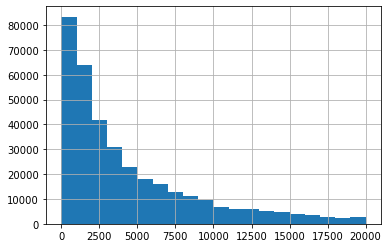

In [19]:
df.price.hist(bins=20)

In [20]:
len(df.query('price==0'))/len(df)

0.030398035923412302

Data with a zero price is only 3%, I will delete them.

In [21]:
df = df.query('price!=0')

In the year of registration, there are values ​​more than 2022 and less than 1950. I'll look at their amount.

<AxesSubplot:>

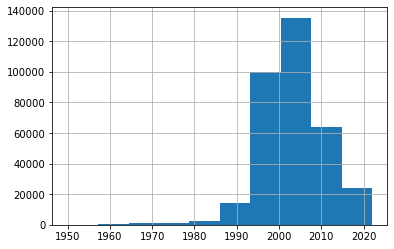

In [22]:
df.registration_year.hist(range=(1950, 2022), bins=10)

In [23]:
len(df.query('registration_year<1950 or registration_year>2016'))/len(df)

0.04062364483560492

Not much. I'll delete them too.

In [24]:
df = df.query('registration_year>1950 or registration_year<2016')

In [25]:
df['date_crawled'].describe()

count                  343593
unique                 265135
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: date_crawled, dtype: object

Remained anomalous values in power.

<AxesSubplot:>

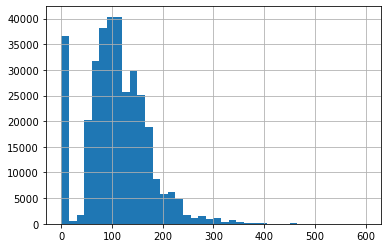

In [26]:
df.power.hist(range=(0, 600), bins=40)

In [27]:
len(df.query('power>600'))

361

I will remove a small number of values with too much power.

In [28]:
df = df.query('power<600')

Number of cars with zero power:

In [29]:
len(df.query('power==0'))/len(df)

0.10593695643939946

I will replace 10% of zero values with an average power value.

In [30]:
df.power = df.power.replace(0, df.power.mean())
df.power = df.power.astype('int')

The number_of_pictures column contains only zeros.

In [31]:
df.number_of_pictures.unique()

array([0])

Also, I will not use this column in training.

### Dates

In [32]:
df.date_created.describe()

count                  343223
unique                    109
top       2016-04-03 00:00:00
freq                    13329
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: date_created, dtype: object

In [33]:
df.last_seen.describe()

count                  343223
unique                 174389
top       2016-04-06 13:45:54
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: last_seen, dtype: object

In [34]:
df.date_crawled.describe()

count                  343223
unique                 264929
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: date_crawled, dtype: object

In [35]:
df.postal_code.describe()

count    343223.000000
mean      50688.534562
std       25744.531616
min        1067.000000
25%       30449.000000
50%       49525.000000
75%       71229.000000
max       99998.000000
Name: postal_code, dtype: float64

Dates of creation, download and last activity, as well as the index, are within one month and do not carry important information for training models. I won't use them.

## Model training

### Create selections

In [36]:
#target and features
features = df.drop(['price','number_of_pictures', 'vehicle_type', 
                    'date_created', 'last_seen', 'date_crawled', 'postal_code'], axis=1)
target = df['price']
numerical = list(features.select_dtypes(include=['int64']).columns)
categorical = list(features.select_dtypes(include=['object', 'category']).columns)
features[categorical] = features[categorical].astype('category')

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=12345)

### Linear regression

To begin with, I will take the linear regression model as the least accurate, but the fastest.

Linear regression requires feature encoding and scaling.

In [38]:
start = time.time()

t = [('cat', OneHotEncoder(handle_unknown = 'ignore'), 
      categorical), ('num', StandardScaler(), numerical)]
col_transform = ColumnTransformer(transformers=t)
model = LinearRegression()
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

rmse_lr_pipe = -1*cross_val_score(pipeline, features_train, target_train, 
                                  cv=3, scoring='neg_root_mean_squared_error')

pipeline = clone(pipeline)
pipeline.fit(features_train, target_train)
rmse_lr = np.mean(rmse_lr_pipe)
rmse_lr_test = mean_squared_error(target_test, pipeline.predict(features_test), squared=False)

end = time.time()
time_lr = end - start

In [39]:
print('RMSE for regression model:', rmse_lr)
print('Time:', time_lr)
print("rmse on test data:", rmse_lr_test)

RMSE for regression model: 2883.0054377292267
Time: 25.51385998725891
rmse on test data: 2900.84634399913


### LightGBM

I'll start with the default values.

In [40]:
#default hyperparameters
start = time.time()

model = lgb.LGBMRegressor()

rmse_lgb = -1*cross_val_score(model, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')

rmse_lgb_default = np.mean(rmse_lgb)
model = clone(model)
model.fit(features_train, target_train)
rmse_lgb_default_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_lgb_default = end - start

In [41]:
print('RMSE LightGBM:', int(rmse_lgb_default))
print('Time LightGBM:', int(time_lgb_default))
print("RMSE on test data:", rmse_lgb_default_test)

RMSE LightGBM: 1743
Time LightGBM: 2
RMSE on test data: 1737.5469405548126


In [42]:
#faster
start = time.time()

model = lgb.LGBMRegressor(num_leaves=10, max_depth=2,n_estimators=50, learning_rate=0.5)

rmse_lgb = -1*cross_val_score(model, 
                              features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')

rmse_lgb_fast = np.mean(rmse_lgb)

model = clone(model)
model.fit(features_train, target_train)
rmse_lgb_fast_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_lgb_fast = end - start

In [43]:
print('RMSE LightGBM:', int(rmse_lgb_fast))
print('Time LightGBM:', int(time_lgb_fast))
print("RMSE on test data:", rmse_lgb_fast_test)

RMSE LightGBM: 1975
Time LightGBM: 0
RMSE on test data: 1977.979858983996


In [44]:
#more precise
start = time.time()

model = lgb.LGBMRegressor(num_leaves=431, max_depth=-1,n_estimators=500, learning_rate=0.1)

rmse_lgb = -1*cross_val_score(model, 
                              features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')

rmse_lgb_precise = np.mean(rmse_lgb)

model = clone(model)
model.fit(features_train, target_train)
rmse_lgb_precise_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_lgb_precise = end - start

In [45]:
print('RMSE LightGBM:', int(rmse_lgb_precise))
print('Time LightGBM:', int(time_lgb_precise))
print("RMSE on test data:", rmse_lgb_precise_test)

RMSE LightGBM: 1657
Time LightGBM: 30
RMSE on test data: 1616.0595679928556


### Catboost

In [46]:
#default
start = time.time()

model = CatBoostRegressor(cat_features=categorical, verbose=1000)
rmse_cat = -1*cross_val_score(model, 
                              features_train, target_train, cv=2, scoring='neg_root_mean_squared_error')

rmse_cat_default = np.mean(rmse_cat)
model = clone(model)
model.fit(features_train, target_train)
rmse_cat_default_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_cat_default = end - start

Learning rate set to 0.088206
0:	learn: 4261.2883325	total: 93.3ms	remaining: 1m 33s
999:	learn: 1652.7096343	total: 23s	remaining: 0us
Learning rate set to 0.088206
0:	learn: 4268.3339900	total: 28.1ms	remaining: 28.1s
999:	learn: 1659.5129040	total: 23.6s	remaining: 0us
Learning rate set to 0.098415
0:	learn: 4231.2800941	total: 59.1ms	remaining: 59s
999:	learn: 1658.4132592	total: 43.3s	remaining: 0us


In [47]:
print('RMSE CatBoost:', int(rmse_cat_default))
print('Time CatBoost:', int(time_cat_default))
print("RMSE on test data:", rmse_cat_default_test)

RMSE CatBoost: 1744
Time CatBoost: 91
RMSE on test data: 1721.4877482928382


In [48]:
#faster
start = time.time()

model = CatBoostRegressor(cat_features=categorical, verbose=1000,
                                               learning_rate=0.5, iterations=10)
rmse_cat = -1*cross_val_score(model, 
                              features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')

rmse_cat_fast = np.mean(rmse_cat)
model = clone(model)
model.fit(features_train, target_train)
rmse_cat_fast_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_cat_fast = end - start

0:	learn: 3255.2523759	total: 15.7ms	remaining: 142ms
9:	learn: 2039.2169135	total: 150ms	remaining: 0us
0:	learn: 3241.9190704	total: 15.5ms	remaining: 140ms
9:	learn: 2028.8592562	total: 149ms	remaining: 0us
0:	learn: 3295.7286848	total: 15.1ms	remaining: 136ms
9:	learn: 2040.3034154	total: 147ms	remaining: 0us
0:	learn: 3246.9122918	total: 25.5ms	remaining: 230ms
9:	learn: 2041.2216444	total: 213ms	remaining: 0us


In [49]:
print('RMSE CatBoost:', int(rmse_cat_fast))
print('Time CatBoost:', int(time_cat_fast))
print("RMSE on test data:", rmse_cat_fast_test)

RMSE CatBoost: 2038
Time CatBoost: 1
RMSE on test data: 2037.7432438748808


In [50]:
#more precise
start = time.time()

model = CatBoostRegressor(cat_features=categorical, verbose=1000,
                                               learning_rate=0.3, iterations=100, depth=10)
rmse_cat = -1*cross_val_score(model, 
                              features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')

rmse_cat_precise = np.mean(rmse_cat)
model = clone(model)
model.fit(features_train, target_train)
rmse_cat_precise_test = mean_squared_error(target_test, model.predict(features_test), squared=False)

end = time.time()
time_cat_precise = end - start

0:	learn: 3622.2580931	total: 22.4ms	remaining: 2.22s
99:	learn: 1614.4329797	total: 2.31s	remaining: 0us
0:	learn: 3621.8819811	total: 23.1ms	remaining: 2.28s
99:	learn: 1619.0740937	total: 2.24s	remaining: 0us
0:	learn: 3609.3747182	total: 22.9ms	remaining: 2.27s
99:	learn: 1611.0711766	total: 2.41s	remaining: 0us
0:	learn: 3614.7404069	total: 35.4ms	remaining: 3.51s
99:	learn: 1632.6021791	total: 3.09s	remaining: 0us


In [51]:
print('RMSE CatBoost:', int(rmse_cat_precise))
print('Time CatBoost:', int(time_cat_precise))
print("RMSE on test data:", rmse_cat_precise_test)

RMSE CatBoost: 1744
Time CatBoost: 10
RMSE on test data: 1732.0056059797028


## Analysis of models

In [52]:
models_rmse = pd.DataFrame(data={'model':['LinearRegression', 'LightGBM','LightGBM','LightGBM', 
                                          'CatBoost', 'CatBoost', 'CatBoost'],                               
'parameters':['default', 'default','fast', 'precise', 
              'default', 'fast', 'precise'],
'RMSE':[rmse_lr_test, rmse_lgb_default_test, rmse_lgb_fast_test, rmse_lgb_precise_test, 
        rmse_cat_default_test, rmse_cat_fast_test, rmse_cat_precise_test],
'time':[time_lr, time_lgb_default, time_lgb_fast, time_lgb_precise,
       time_cat_default, time_cat_fast, time_cat_precise]})
models_rmse.set_index(['model'])

,parameters,RMSE,time
model,,,
LinearRegression,default,2900.846344,25.513860
LightGBM,default,1737.546941,2.219168
LightGBM,fast,1977.979859,0.671290
LightGBM,precise,1616.059568,30.425030
CatBoost,default,1721.487748,91.384846
CatBoost,fast,2037.743244,1.335653
CatBoost,precise,1732.005606,10.764473


Linear regression showed the least accuracy. Without using detailed enumeration of hyperparameters, such as GridSearch, the best prediction results were achieved using LightGBM. With the default settings, LightGBM is faster than CatBoost for the same accuracy.

### Conclusions:
* data were prepared for training car price prediction models
* Trained linear regression and gradient boosting models
* gradient boosting is faster than linear regression